In [1]:
import sys
sys.path.append('../')
sys.path.append('../2DKS')
import KS2D
sys.path.append('../WD_models')

### General
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from astropy.io import fits
from astropy.table import Table, Column, MaskedColumn, join, unique
from astropy.table import vstack

from tqdm import tqdm
import pandas as pd
import WD_models

In [2]:
from astropy.table import Table, join_skycoord
from astropy.coordinates import SkyCoord
from astropy import table
import astropy.units as u

c0 = Table.read('data/base_catalog.fits')
nug = fits.open('data/03_wd_rv.fits')
c1 = Table(nug[1].data)
nug = fits.open('data/02_photometry.fits')
c2 = Table(nug[1].data)
nug = fits.open('data/04_ms_rv.fits')
c3 = Table(nug[1].data)

print(len(c3))


catalog = join(c1, c2, keys = 'wd_source_id', join_type = 'inner')
catalog = join(join(join(c0, c1, keys = 'wd_source_id'), c2, keys = 'wd_source_id'), c3, keys='ms_source_id')

582


In [4]:
catalog['g_redshift'] = catalog['wd_rv'] - catalog['radial_velocity']
catalog['eg_redshift'] = np.sqrt(catalog['wd_e_rv']**2 + catalog['radial_velocity_error']**2)
print(len(catalog))

382


In [8]:
model = WD_models.load_model('f', 'f', 'f', 'H')
font_model = model

c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16

def rv_from_radius(radarray, teffarray, lowmass = 'f', midmass = 'f', highmass = 'f'):
    
    if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
        font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')
    else:
        font_model = model

    #     font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')


    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    
    rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**font_model['logteff'],\
                                                z = font_model['mass_array'], interp_type = 'linear')
    
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun
    radius = radarray * radius_sun
    rv = newton_G * mass / (speed_light * radius)

    return rv*1e-3

<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_14266/1503571099.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
/tmp/ipykernel_14266/1503571099.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
/tmp/ipykernel_14266/1503571099.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':


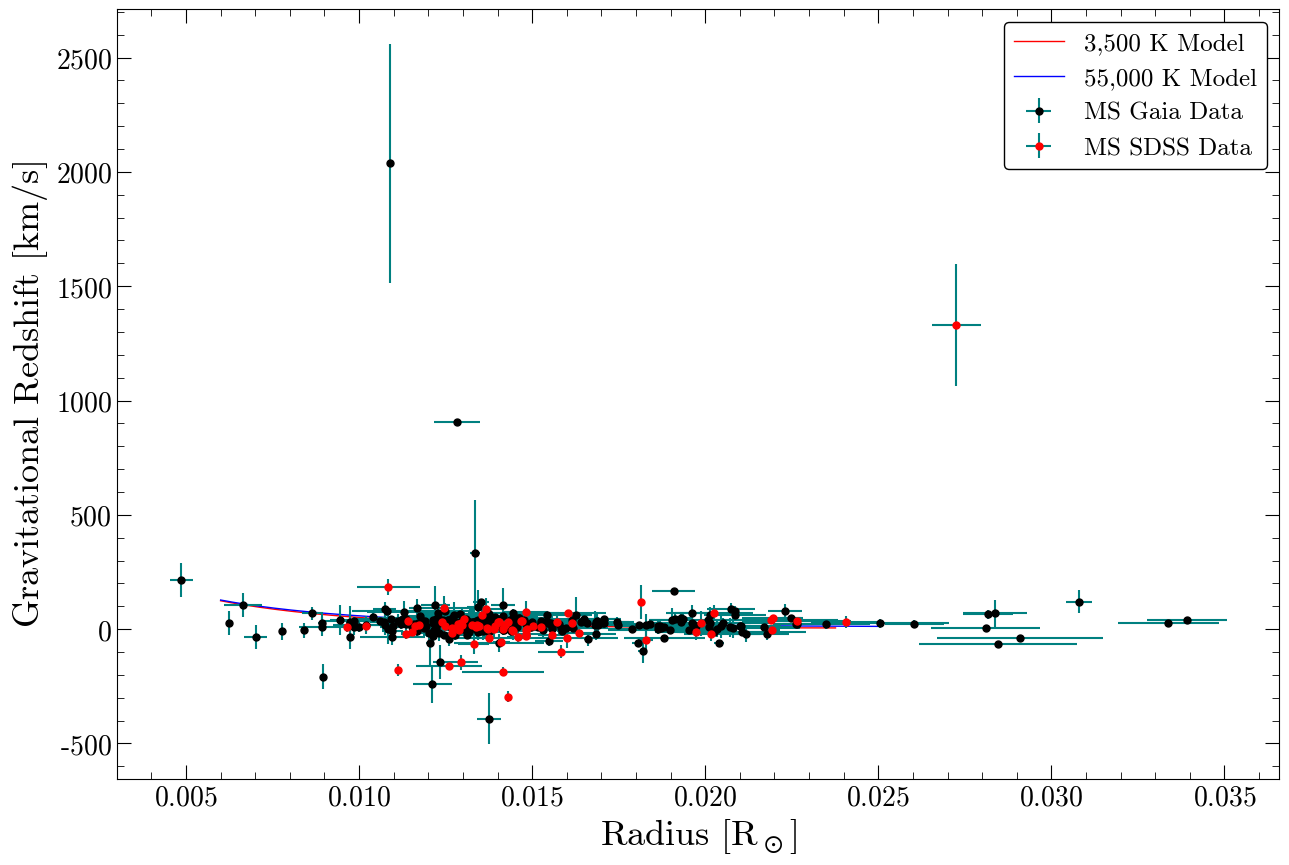

In [10]:
plt.figure(figsize=(15,10))
plt.style.use('./stefan.mplstyle')

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

plt.errorbar(catalog[catalog['ms_rv_from'] == 'gaia']['radius'], catalog[catalog['ms_rv_from'] == 'gaia']['g_redshift'], 
             xerr = catalog[catalog['ms_rv_from'] == 'gaia']['e_radius'], yerr=catalog[catalog['ms_rv_from'] == 'gaia']['eg_redshift'], fmt='o', label = 'MS Gaia Data', color='black', ecolor = 'teal')
plt.errorbar(catalog[catalog['ms_rv_from'] != 'gaia']['radius'], catalog[catalog['ms_rv_from'] != 'gaia']['g_redshift'], 
             xerr = catalog[catalog['ms_rv_from'] != 'gaia']['e_radius'], yerr=catalog[catalog['ms_rv_from'] != 'gaia']['eg_redshift'], fmt='o', label = 'MS SDSS Data', color='Red', ecolor = 'teal')
#plt.errorbar(catalog[catalog['ms_rv_from'] == 'apo']['radius'], catalog[catalog['ms_rv_from'] == 'apo']['g_redshift'], 
#             xerr = catalog[catalog['ms_rv_from'] == 'apo']['e_radius'], yerr=catalog[catalog['ms_rv_from'] == 'apo']['eg_redshift'], fmt='o', label = 'MS APO Data', color='Teal', ecolor = 'teal')


raw_x = catalog['radius']
raw_y = catalog['g_redshift']

raw_dx = catalog['e_radius']
raw_dy = catalog['eg_redshift']

#for i in range(len(catalog[catalog['ms_rv_from'] == 'apo'])):
#    x = catalog[catalog['ms_rv_from'] == 'apo']['radius'][i]
#    y = catalog[catalog['ms_rv_from'] == 'apo']['g_redshift'][i]
 #   plt.plot(x, y, 'bo')
    
#    plt.text(x * (1 - 0.01), y * (1 - 0.01) , ('%2.2f, %2.2f' % (catalog[catalog['ms_rv_from'] == 'apo']['wd_catalog_id_phot'][i], catalog[catalog['ms_rv_from'] == 'apo']['wd_catalog_id'][i])), fontsize=11)

plt.xlabel(r'Radius $[R_\odot]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
#plt.xlim(0.002, 0.027)
#plt.ylim(-20, 135)
plt.legend()

In [13]:
''' GENERATE MASK FROM FLAGS '''

gaia = np.all([catalog['ms_gaia'] == 1], axis = 0)
falcon = np.all([catalog['wd_rv_from'] == 'falcon'], axis = 0)

rechi = np.all([catalog['wd_rechi'] < 5], axis = 0)
wd_redchi = np.all([catalog['redchi'] < 5], axis = 0)
ms_redchi = np.all([catalog['ms_redchi'] < 1.7], axis = 0)

snr = np.all([catalog['snr'] > 10], axis = 0)
hig_snr = np.all([catalog['snr'] > 30], axis = 0)

chance = np.all([catalog['R_chance_align'] < 0.01], axis = 0)

not_da = np.ones(len(catalog))
for i in range(len(not_da)):
    if catalog['wd_catalog_id'][i] in [143.0, 345]:
        not_da[i] = 0

#corv_err = np.all([catalog['eg_redshift'] < 100], axis = 0)

nto = np.all([ms_redchi, wd_redchi, rechi, snr, chance, not_da], axis = 0)
mask =  np.any([catalog['ms_rv_from'] == 'apo', np.all([ms_redchi, wd_redchi, rechi, snr, chance, not_da], axis = 0)], axis = 0)
hrmask =  np.any([catalog['ms_rv_from'] == 'apo', np.all([ms_redchi, wd_redchi, rechi, hig_snr, chance, not_da], axis = 0)], axis = 0)


from_gaia = np.all([ms_redchi, wd_redchi, rechi, snr, chance, not_da, gaia], axis = 0)
from_sdss= np.all([ms_redchi, wd_redchi, rechi, snr, chance, not_da, ~gaia], axis = 0)
from_falcon= np.all([ms_redchi, wd_redchi, rechi, snr, chance, not_da, falcon], axis = 0)

print(len(catalog[nto]))
print(len(catalog[mask]))

215
215


35


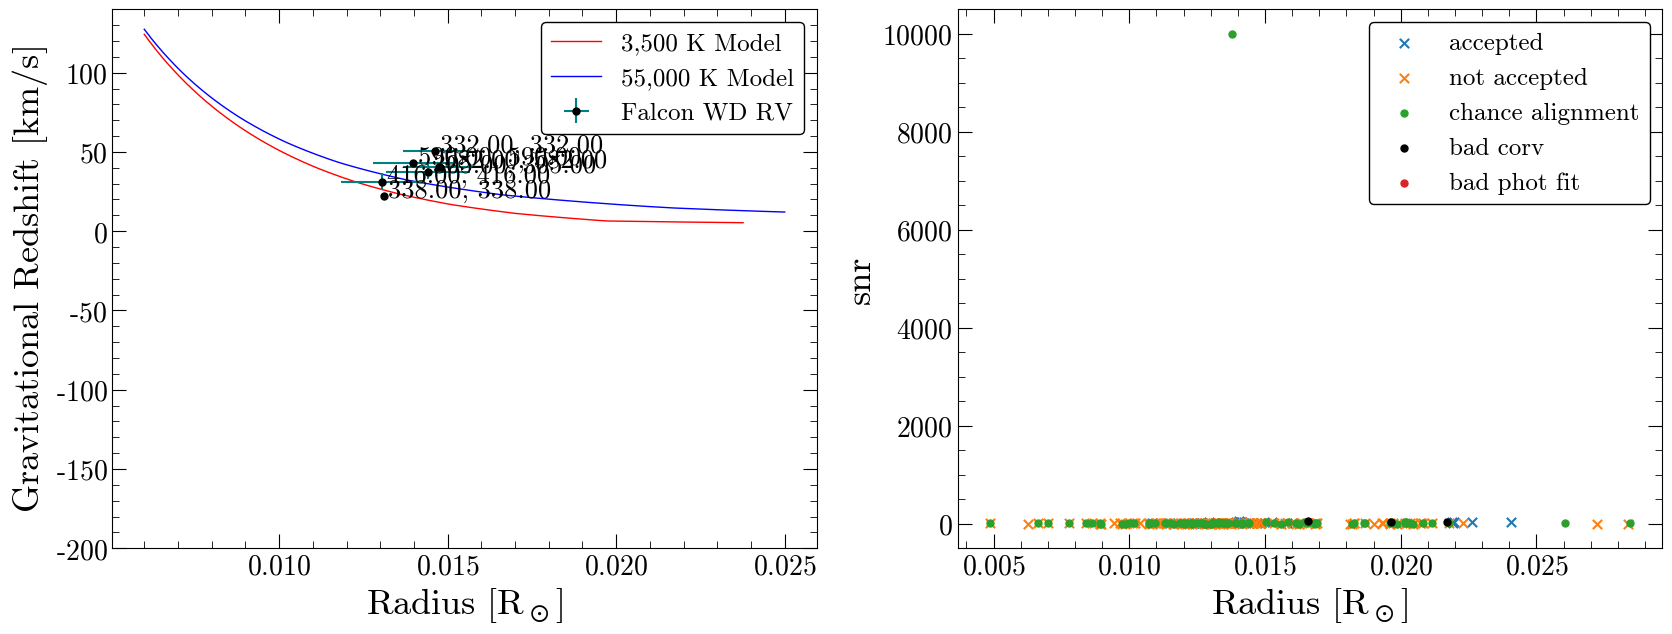

In [18]:
''' PLOTTING '''

plt.figure(figsize=(20,7))

plt.subplot(1,2,1) 

plt.style.use('./stefan.mplstyle')

# Theoretical Tracks

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

for i in range(len(catalog['radius'][from_falcon])):
    x = catalog['radius'][from_falcon][i]
    y = catalog['g_redshift'][from_falcon][i]
 #   plt.plot(x, y, 'bo')
    
    #if (0.006 < x < 0.025) and (-50 < y < 120):
    plt.text(x * (1 + 0.01), y * (1 - 0.01) , ('%2.2f, %2.2f' % (catalog['wd_catalog_id_phot'][from_falcon][i], catalog['wd_catalog_id'][from_falcon][i])), fontsize=19)
    
# Data


plt.errorbar(catalog['radius'][from_falcon], catalog['g_redshift'][from_falcon], xerr = catalog['e_radius'][from_falcon], yerr=catalog['eg_redshift'][from_falcon], fmt='o', 
             label = 'Falcon WD RV', color='black', ecolor = 'teal')
#plt.errorbar(catalog['radius'][from_sdss], catalog['g_redshift'][from_sdss], xerr = catalog['e_radius'][from_sdss], yerr=catalog['eg_redshift'][from_sdss], fmt='o', 
#             label = 'SDSS MS RV', color='red', ecolor = 'teal')

print(len(catalog['radius'][from_sdss]))

#plt.errorbar(catalog['radius'][catalog['wd_catalog_id'] == 49], catalog['g_redshift'][catalog['wd_catalog_id'] == 49],
#            xerr = catalog['e_radius'][catalog['wd_catalog_id'] == 49], yerr = catalog['eg_redshift'][catalog['wd_catalog_id'] == 49])

#plt.scatter(catalog['radius'][catalog['wd_catalog_id'] == 26], catalog['g_redshift'][catalog['wd_catalog_id'] == 26])


refs = Table.read('sdss5/ms_gaia_wd_sdss5.fits')
ms_stuff = Table.read('data/ms_sdss4_wd_sdss4.fits')

#for i in range(len(c2)):
#    if (c2['wd_source_id'][i] in refs['wd_source_id']):
#        plt.axvline(x=c2['radius'][i], ls='--', c='red', lw=0.3)
#    elif (c2['wd_source_id'][i] in refs['wd_source_id']):
#        plt.axvline(x=c2['radius'][i], ls=':', c='green', lw=0.3)
#

plt.xlabel(r'Radius $[R_\odot]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
#plt.xlim(0.006, 0.025)
plt.ylim(-200, 140)
plt.legend()

plt.subplot(1,2,2) 

#plt.figure(figsize=(10,7))
plt.style.use('./stefan.mplstyle')


#plt.scatter(catalog['radius'], catalog['snr'], label='base')
plt.scatter(catalog['radius'][from_sdss], catalog['snr'][from_sdss], label='accepted', marker = 'x', s = 45)
plt.scatter(catalog['radius'][~snr], catalog['snr'][~snr], label='not accepted', marker = 'x', s = 45)
plt.scatter(catalog['radius'][~chance], catalog['snr'][~chance], label='chance alignment')
plt.scatter(catalog['radius'][~rechi], catalog['snr'][~rechi], label='bad corv', color = 'black')
plt.scatter(catalog['radius'][~wd_redchi], catalog['snr'][~wd_redchi], label='bad phot fit')


#for i in range(len(catalog['radius'])):
#    x = catalog['radius'][i]
#    y = catalog['snr'][i]
#    plt.text(x * (1 + 0.01), y * (1 - 0.01) , ('%2.2f' % (catalog['wd_catalog_id'][i])), fontsize=11)


plt.xlabel(r'Radius $[R_\odot]$')
plt.ylabel(r'snr')
plt.legend()

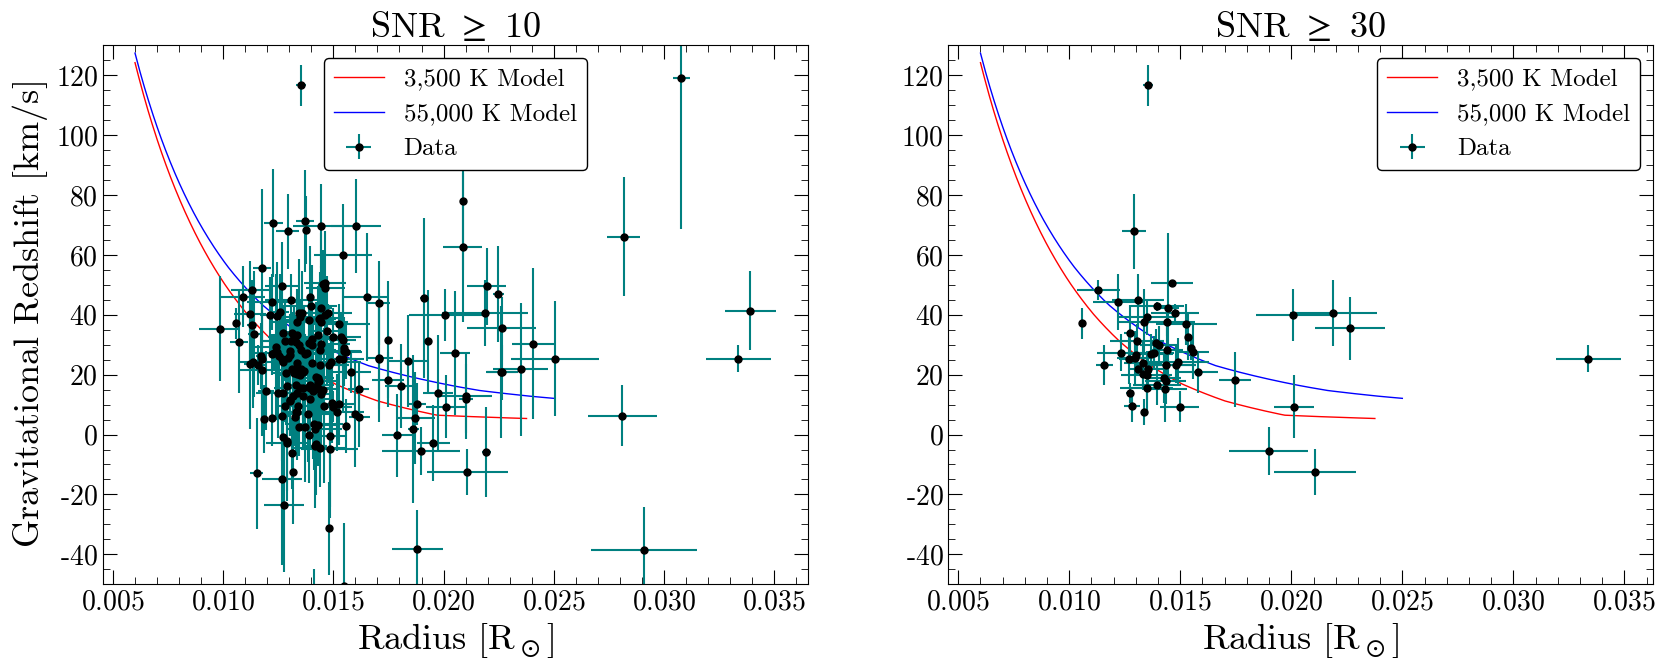

In [20]:
''' PLOTTING '''

fig = plt.figure(figsize=(20,7))
plt.subplot(1,2,1) 
plt.style.use('./stefan.mplstyle')

# Theoretical Tracks

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

# Data

plt.errorbar(catalog['radius'][mask], catalog['g_redshift'][mask], xerr = catalog['e_radius'][mask], yerr = catalog['eg_redshift'][mask], fmt='o', label = 'Data', color='black', ecolor = 'teal')

#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)

plt.ylim(-50, 130)

#plt.axvline(x=0.01)

plt.xlabel(r'Radius $[R_\odot]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.title(r'SNR $\geq$ 10', fontsize=26)
plt.legend()

plt.subplot(1,2,2) 
plt.style.use('./stefan.mplstyle')

# Theoretical Tracks

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

# Data

plt.errorbar(catalog['radius'][hrmask], catalog['g_redshift'][hrmask], xerr = catalog['e_radius'][hrmask], yerr = catalog['eg_redshift'][hrmask], fmt='o', label = 'Data', color='black', ecolor = 'teal')

#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)
plt.ylim(-50, 130)

plt.xlabel(r'Radius $[R_\odot]$')
#plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.title(r'SNR $\geq$ 30', fontsize=26)
plt.legend()
#plt.colorbar()

plt.savefig('spectra/curve_withhighsnr.pdf')

In [24]:
a = 0
b = 0
c = 0

for i in catalog['wd_rv_from'][mask]:
    if i == 'sdss5':
        a += 1
    elif i == 'sdss4':
        b += 1
    elif i == 'falcon':
        c += 1

print('sdss5: {}'.format(a))
print('sdss4: {}'.format(b))
print('falcon: {}'.format(c))
print('total: {}'.format(a+b+c))

sdss5: 77
sdss4: 132
falcon: 6
total: 215


In [25]:
a = 0
b = 0
c = 0

for i in catalog['ms_rv_from'][mask]:
    if i == 'sdss5':
        a += 1
    elif i == 'sdss4':
        b += 1
    elif i == 'gaia':
        c += 1

print('sdss5: {}'.format(a))
print('sdss4: {}'.format(b))
print('gaia: {}'.format(c))
print('total: {}'.format(a+b+c))

sdss5: 31
sdss4: 4
gaia: 180
total: 215


In [58]:
a = 0
b = 0
c = 0

for i in catalog['radius'][mask]:
    if i < 0.01:
        a += 1
    elif (0.01 <= i < 0.015):
        b += 1
    elif i >= 0.015:
        c += 1

print('high mass: {}'.format(a))
print('mid mass: {}'.format(b))
print('low mass: {}'.format(c))
print('total: {}'.format(a+b+c))

high mass: 1
mid mass: 150
low mass: 64
total: 215


Text(0, 0.5, 'bp-rp')

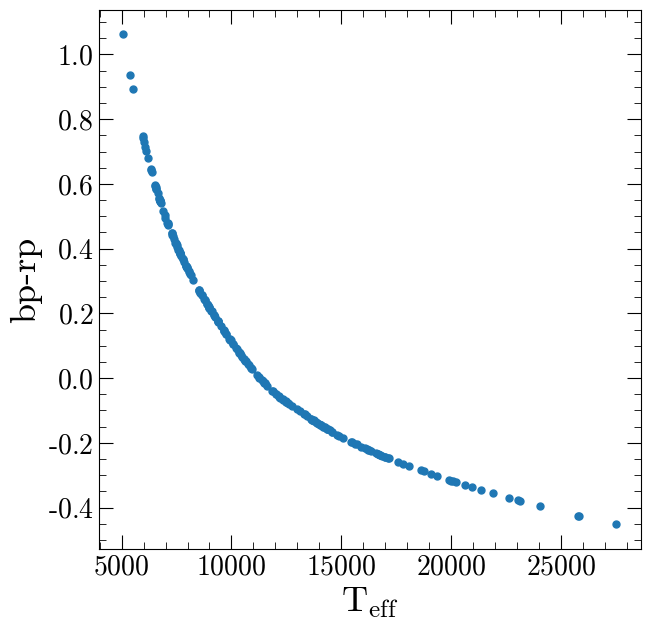

In [30]:
plt.scatter(catalog['phot_teff'][mask], catalog['wd_bp_rp'][mask])
plt.xlabel(r'$T_{eff}$')
plt.ylabel('bp-rp')

In [31]:
catalog['ms_bp_rp'] = catalog['ms_phot_bp_mean_mag'] - catalog['ms_phot_rp_mean_mag']
catalog['ms_m_g'] = catalog['ms_phot_g_mean_mag'] + 5 * np.log10(catalog['ms_parallax'] / 100)

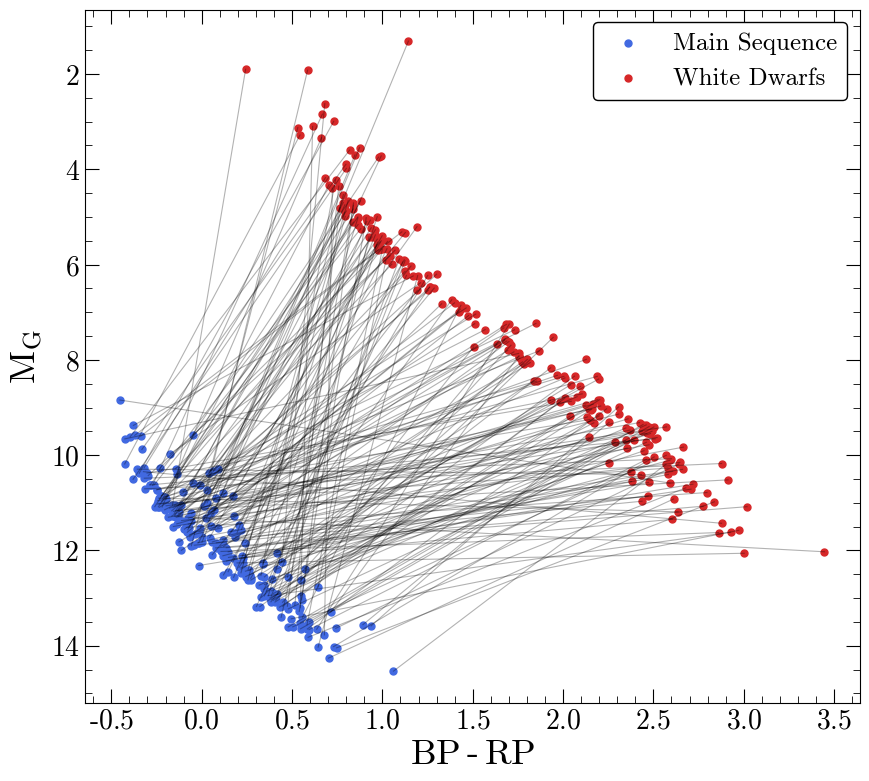

In [32]:
plt.figure(figsize=(10,9))

plt.scatter(catalog['wd_bp_rp'][mask], catalog['wd_m_g'][mask], c = 'royalblue', label='Main Sequence')
plt.scatter(catalog['ms_bp_rp'][mask], catalog['ms_m_g'][mask], c = 'C3', label='White Dwarfs')

for i in range(len(catalog[mask])):
    plt.plot([catalog['wd_bp_rp'][mask][i], catalog['ms_bp_rp'][mask][i]], [catalog['wd_m_g'][mask][i], catalog['ms_m_g'][mask][i]], c = 'k', ls='-', alpha=0.3, lw = 0.8)

plt.gca().invert_yaxis()

plt.ylabel(r'$M_G$')
plt.xlabel(r'$BP-RP$')

plt.legend()
plt.savefig('spectra/cmd.pdf')

In [34]:
print(np.median(catalog['sep_AU'][mask]))

2449.9946395564466


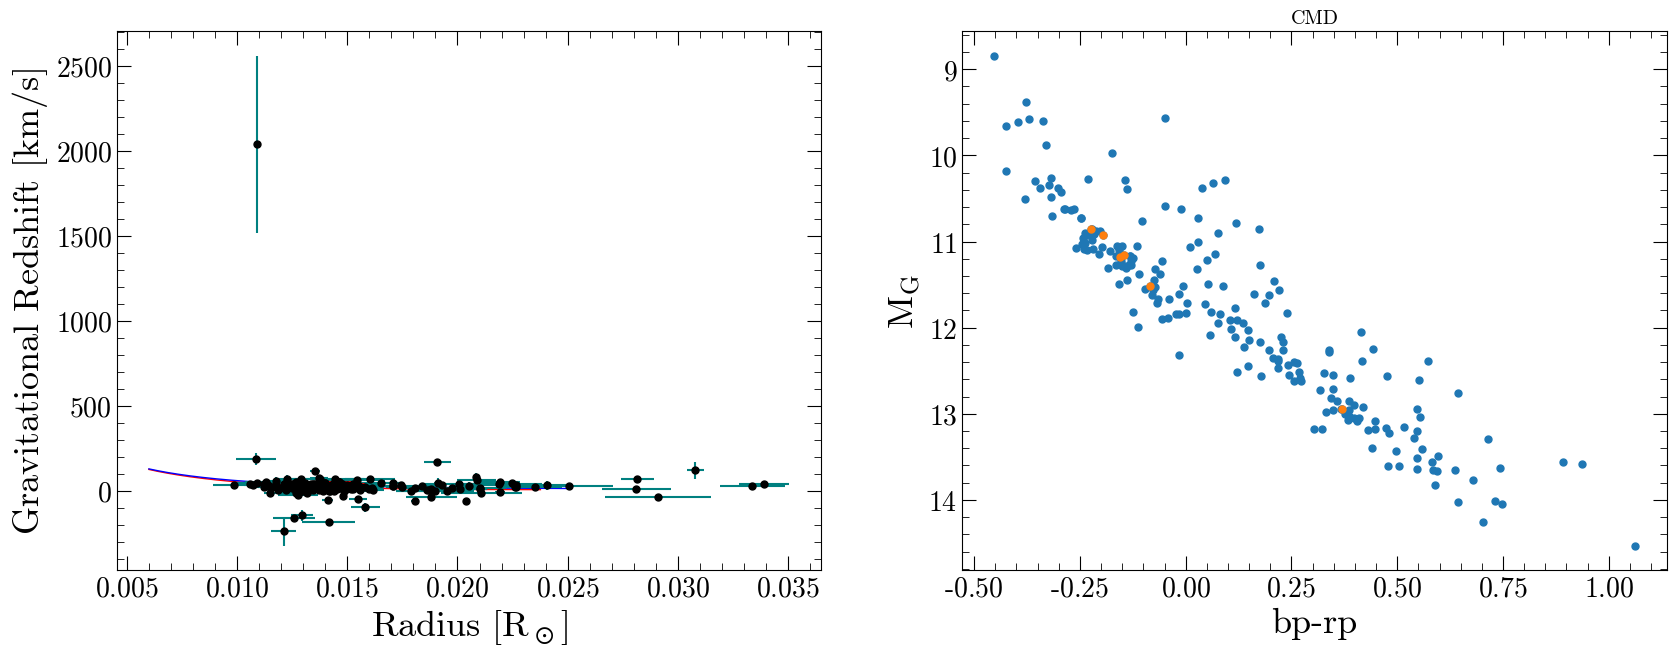

In [36]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1) 

plt.style.use('./stefan.mplstyle')

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)


plt.errorbar(catalog['radius'][mask], catalog['g_redshift'][mask], xerr = catalog['e_radius'][mask], yerr = catalog['eg_redshift'][mask], fmt='o', label = 'Data', color='black', ecolor = 'teal')
plt.errorbar(catalog['radius'][from_falcon], catalog['g_redshift'][from_falcon], xerr = catalog['e_radius'][from_falcon], yerr = catalog['eg_redshift'][from_falcon], fmt='o', label = 'Data', color='black', ecolor = 'red')

#
#for i in range(len(catalog['radius'][mask])):
#    x = catalog['radius'][mask][i]
#    y = catalog['g_redshift'][mask][i]
#    plt.text(x, y , ('%2.2f' % (catalog['wd_catalog_id_phot'][mask][i])), fontsize=11)
    
plt.xlabel(r'Radius $[R_\odot]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')

plt.subplot(1,2,2) 

plt.style.use('./stefan.mplstyle')
plt.scatter(catalog['wd_bp_rp'][mask], catalog['wd_m_g'][mask])
plt.scatter(catalog['wd_bp_rp'][from_falcon], catalog['wd_m_g'][from_falcon])

#for i in range(len(catalog['radius'][mask])):
#    x = catalog['wd_bp_rp'][mask][i]
#    y = catalog['wd_m_g'][mask][i]
#    plt.text(x * (1 + 0.001), y * (1 - 0.001) , ('%2.2f' % (catalog['wd_catalog_id_phot'][mask][i])), fontsize=11)
    
plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.title(r'CMD')
plt.gca().invert_yaxis()

Text(0.5, 0, '$T_{eff}$')

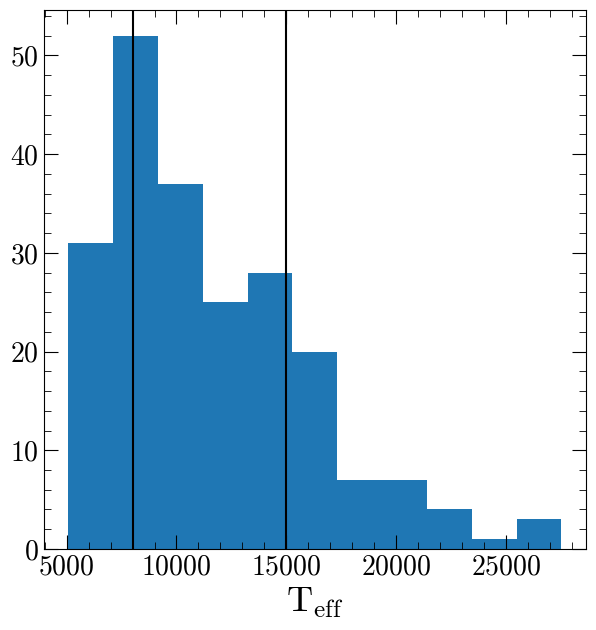

In [38]:
plt.hist(catalog['phot_teff'][mask])
plt.axvline(8000, c='k')
plt.axvline(15000, c='k')
plt.xlabel(r'$T_{eff}$')

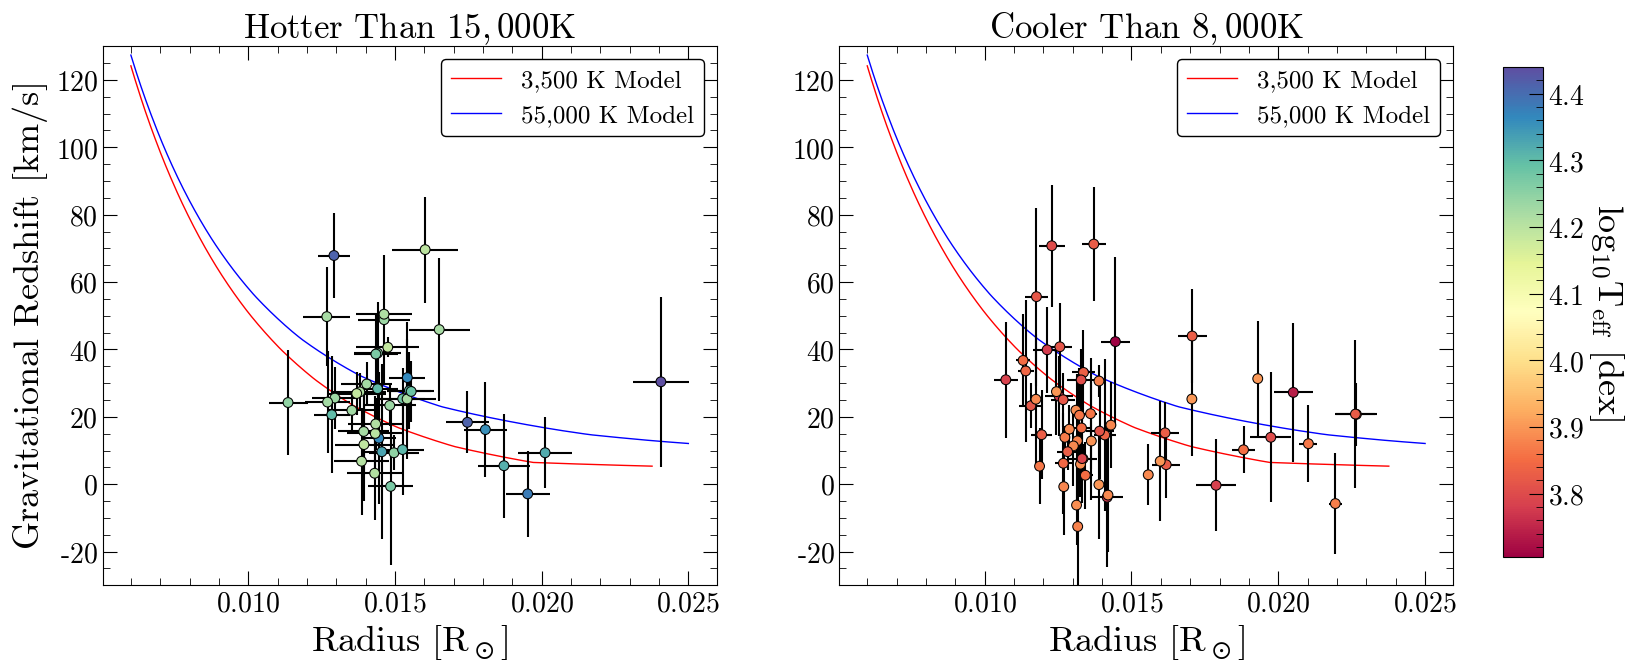

In [57]:
hot_catalog = np.all([catalog['phot_teff'] > 15000], axis = 0)
cool_catalog = np.all([catalog['phot_teff'] < 8000], axis = 0)

hot_mask = np.all([hot_catalog, mask], axis = 0)

cool_mask = np.all([cool_catalog, mask], axis = 0)

''' PLOTTING '''

fig = plt.figure(figsize=(20,7))
plt.subplot(1,2,1) 
plt.style.use('./stefan.mplstyle')

# Theoretical Tracks

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

# Data

a = plt.scatter(catalog['radius'][hot_mask], catalog['g_redshift'][hot_mask],
             c=np.log10(catalog['phot_teff'][hot_mask]), cmap = plt.cm.Spectral, zorder = 10, vmin=min(np.log10(catalog['phot_teff'][mask])), vmax=max(np.log10(catalog['phot_teff'][mask])),
              s = 50, edgecolor='k', lw = 0.75)

plt.errorbar(catalog['radius'][hot_mask], catalog['g_redshift'][hot_mask], xerr = catalog['e_radius'][hot_mask], yerr = catalog['eg_redshift'][hot_mask], fmt=' ', ecolor = 'black')

#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)

plt.ylim((-30,130))

plt.xlabel(r'Radius $[R_\odot]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.title(r'Hotter Than $15,000$K', fontsize = 25)
plt.legend()

plt.subplot(1,2,2) 
plt.style.use('./stefan.mplstyle')

# Theoretical Tracks

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

# Data

a = plt.scatter(catalog['radius'][cool_mask], catalog['g_redshift'][cool_mask],
             c=np.log10(catalog['phot_teff'][cool_mask]), cmap = plt.cm.Spectral, zorder = 10, vmin=min(np.log10(catalog['phot_teff'][mask])), vmax=max(np.log10(catalog['phot_teff'][mask])),
               s = 50, edgecolor='k', lw = .75)

plt.errorbar(catalog['radius'][cool_mask], catalog['g_redshift'][cool_mask], xerr = catalog['e_radius'][cool_mask], yerr = catalog['eg_redshift'][cool_mask], fmt=' ', ecolor = 'black')

#plt.xticks(fontsize=25)
#plt.yticks(fontsize=25)

plt.xlabel(r'Radius $[R_\odot]$')
plt.ylim((-30,130))

#plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.title(r'Cooler Than $8,000$K', fontsize=25)
plt.legend()
#plt.colorbar()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.825, 0.15, 0.02, 0.7])
cbar = fig.colorbar(a, cax=cbar_ax)
cbar.ax.get_yaxis().labelpad = 30
cbar.set_label(r'$log_{10}T_{eff}$ $[dex]$', rotation = 270)

plt.savefig('spectra/temps_2plots_color.pdf')

In [40]:
arr1 = np.array([catalog['radius'][hot_mask], catalog['g_redshift'][hot_mask]])
arr2 = np.array([catalog['radius'][cool_mask], catalog['g_redshift'][cool_mask]])

print(KS2D.ks2d2s(arr1, arr2))

(0.37441860465116283, 0.0060376267975056465)


In [56]:
print(np.nanmedian(catalog['e_radius'][mask]))

0.0006540363765165681


In [42]:
print(min(catalog['ms_parallax_over_error_1'][mask]))

6.88493


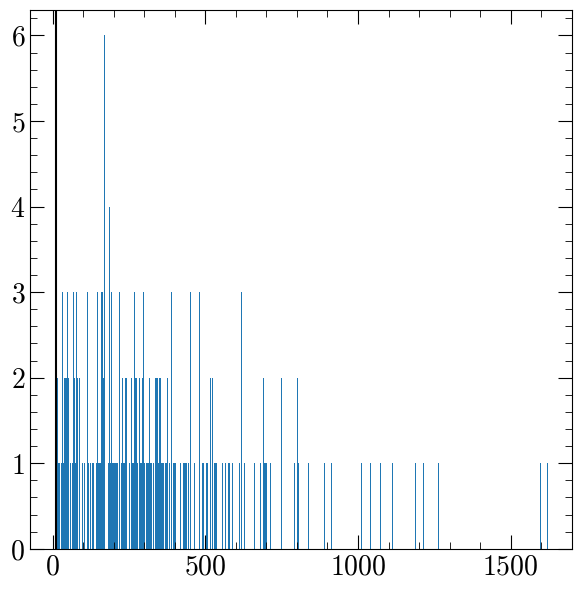

In [43]:
plt.hist(catalog['ms_parallax_over_error_1'][mask], bins = 500)
#plt.xlim(0,100)
plt.axvline(x = 10, c = 'black')

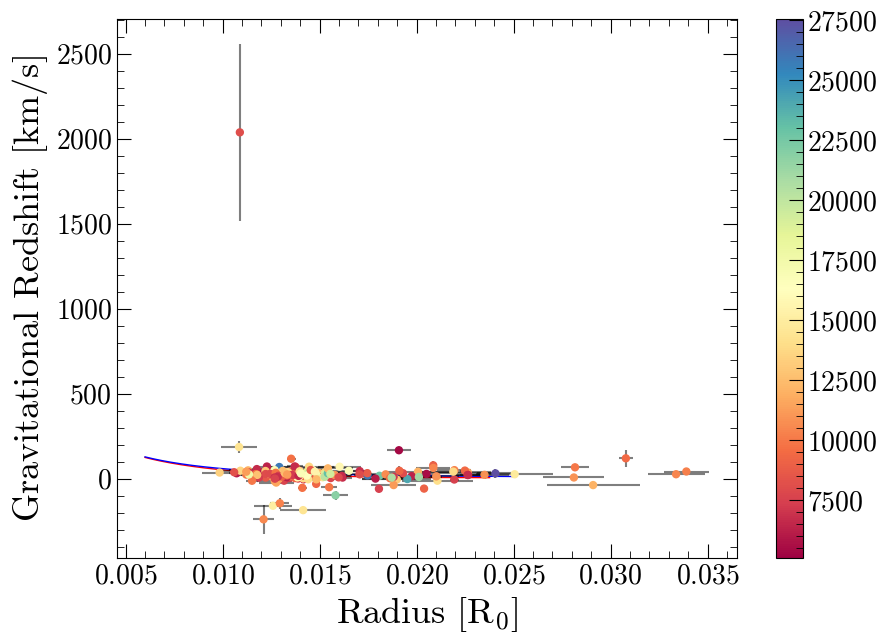

In [44]:
plt.figure(figsize=(10,7))

plt.style.use('./stefan.mplstyle')

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)


colors = plt.cm.Spectral(catalog['phot_teff'])

plt.scatter(catalog['radius'][mask], catalog['g_redshift'][mask], label = 'Data', 
             c=catalog['phot_teff'][mask], cmap = plt.cm.Spectral, zorder = 10)

plt.errorbar(catalog['radius'][mask], catalog['g_redshift'][mask], xerr = catalog['e_radius'][mask], yerr = catalog['eg_redshift'][mask], fmt=' ', label = 'Data',ecolor = 'black', alpha = 0.5)
#plt.errorbar(catalog['radius'][from_falcon], catalog['g_redshift'][from_falcon], xerr = catalog['e_radius'][from_falcon], yerr = catalog['eg_redshift'][from_falcon], fmt='o', label = 'Data',  
#             colors=colors, ecolor = 'teal')



    
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.colorbar()

In [45]:
rvs_10000 = rv_from_radius(rsuns, 10000, 'f', 'f', 'f')
ts = []

for i in range(len(catalog)):
    exp = np.interp(catalog['radius'][i], rsuns, rvs_10000)
    
    t = (catalog['g_redshift'][i] - exp) / (catalog['eg_redshift'][i])
    ts.append(t)
    
catalog['t_from_10000'] = ts

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


     g_redshift     
--------------------
-0.07487248345578124
   3.248886613699643
   9.327819526537553
 -160.01650789181923
    28.8919718471872
   67.88574339113444
  13.649380671435345
   25.55672138398795
   49.74030708535437
   27.39429720688093
                 ...
   14.29008392144766
   24.24047207840001
  15.653916679945013
  11.756869780978288
    38.6358034513023
   28.33952591493385
    36.2470657817085
  17.885192500177176
    40.6515417098999
  29.736039892910085
Length = 37 rows
KstestResult(statistic=0.24126565589980223, pvalue=0.08348973366417306, statistic_location=-0.7374472569775055, statistic_sign=-1)


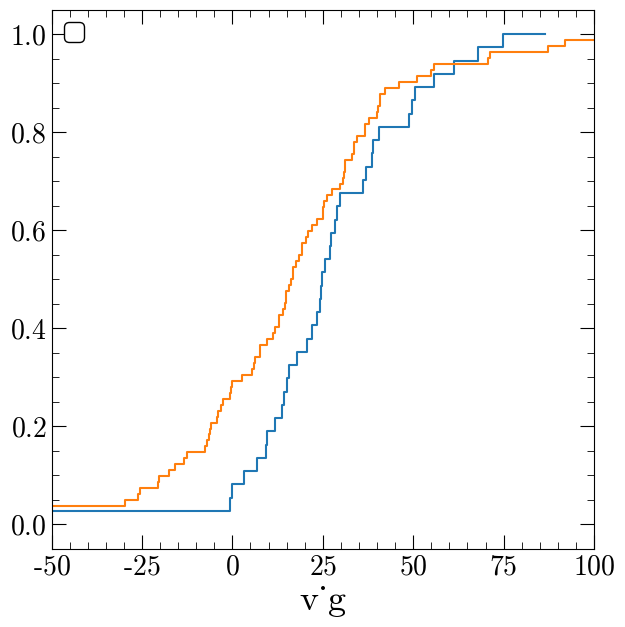

In [46]:
from scipy import stats

# https://halweb.uc3m.es/esp/Personal/personas/dpena/articles/kolpl97.pdf

mid_radius = np.all([catalog['radius'] < 0.015, catalog['radius'] > 0.01], axis = 0)
hot_rad_mask = np.all([hot_catalog, mid_radius, ~np.isnan(catalog['g_redshift'])], axis = 0)
cool_rad_mask = np.all([cool_catalog, mid_radius, ~np.isnan(catalog['g_redshift'])], axis = 0)

#plt.hist(catalog['g_redshift'][hot_rad_mask], alpha = 0.5, label = 'Hot Stars', density=True, cumulative=1)
#plt.hist(catalog['g_redshift'][cool_rad_mask], alpha = 0.5, label = 'Cool Stars', density=True, cumulative=1)

#plt.axvline(x = np.mean(catalog['g_redshift'][hot_rad_mask], alpha = 0.3))

print(catalog['g_redshift'][hot_rad_mask])

hot_res = stats.ecdf(catalog['g_redshift'][hot_rad_mask])
cool_res = stats.ecdf(catalog['g_redshift'][cool_rad_mask])

ax = plt.subplot()

hot_res.cdf.plot(ax)
cool_res.cdf.plot(ax)

print(stats.ks_2samp(catalog['g_redshift'][hot_rad_mask], catalog['g_redshift'][cool_rad_mask]))

plt.xlim(-50,100)
#plt.xticks(range(-10, 10), fontsize = 10)
plt.xlabel(r'v_g')
plt.legend()

In [47]:
print(np.mean(catalog['t_from_10000'][cool_mask]))

nan
